# Galaxy and Quasars II

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [1]:
import emcee
import corner
import numpy as np
from scipy import stats
from astropy.table import Table
import pandas as pd

from astroML.utils import completeness_contamination
from astroML.utils.decorators import pickle_results
from astroML.utils import split_samples
from astroML.classification import GMMBayes
from astroML.resample import bootstrap

import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Fetch and visualzie the data

In [2]:
data = pd.read_csv('../solutions/galaxyquasar.csv')

data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
u_g = np.array(data['u']-data['g'])
g_r = np.array(data['g']-data['r'])
r_i = np.array(data['r']-data['i'])
i_z = np.array(data['i']-data['z'])

labels = data['class']

In [4]:
ND_dataset = np.array([u_g, g_r, r_i, i_z]).T
labels_01  = np.where(labels=='QSO', 1, 0)    # 1=QSO, 0=GALAXY
legends    = ['u-g', 'g-r', 'r-i', 'i-z']

### CornerPlot

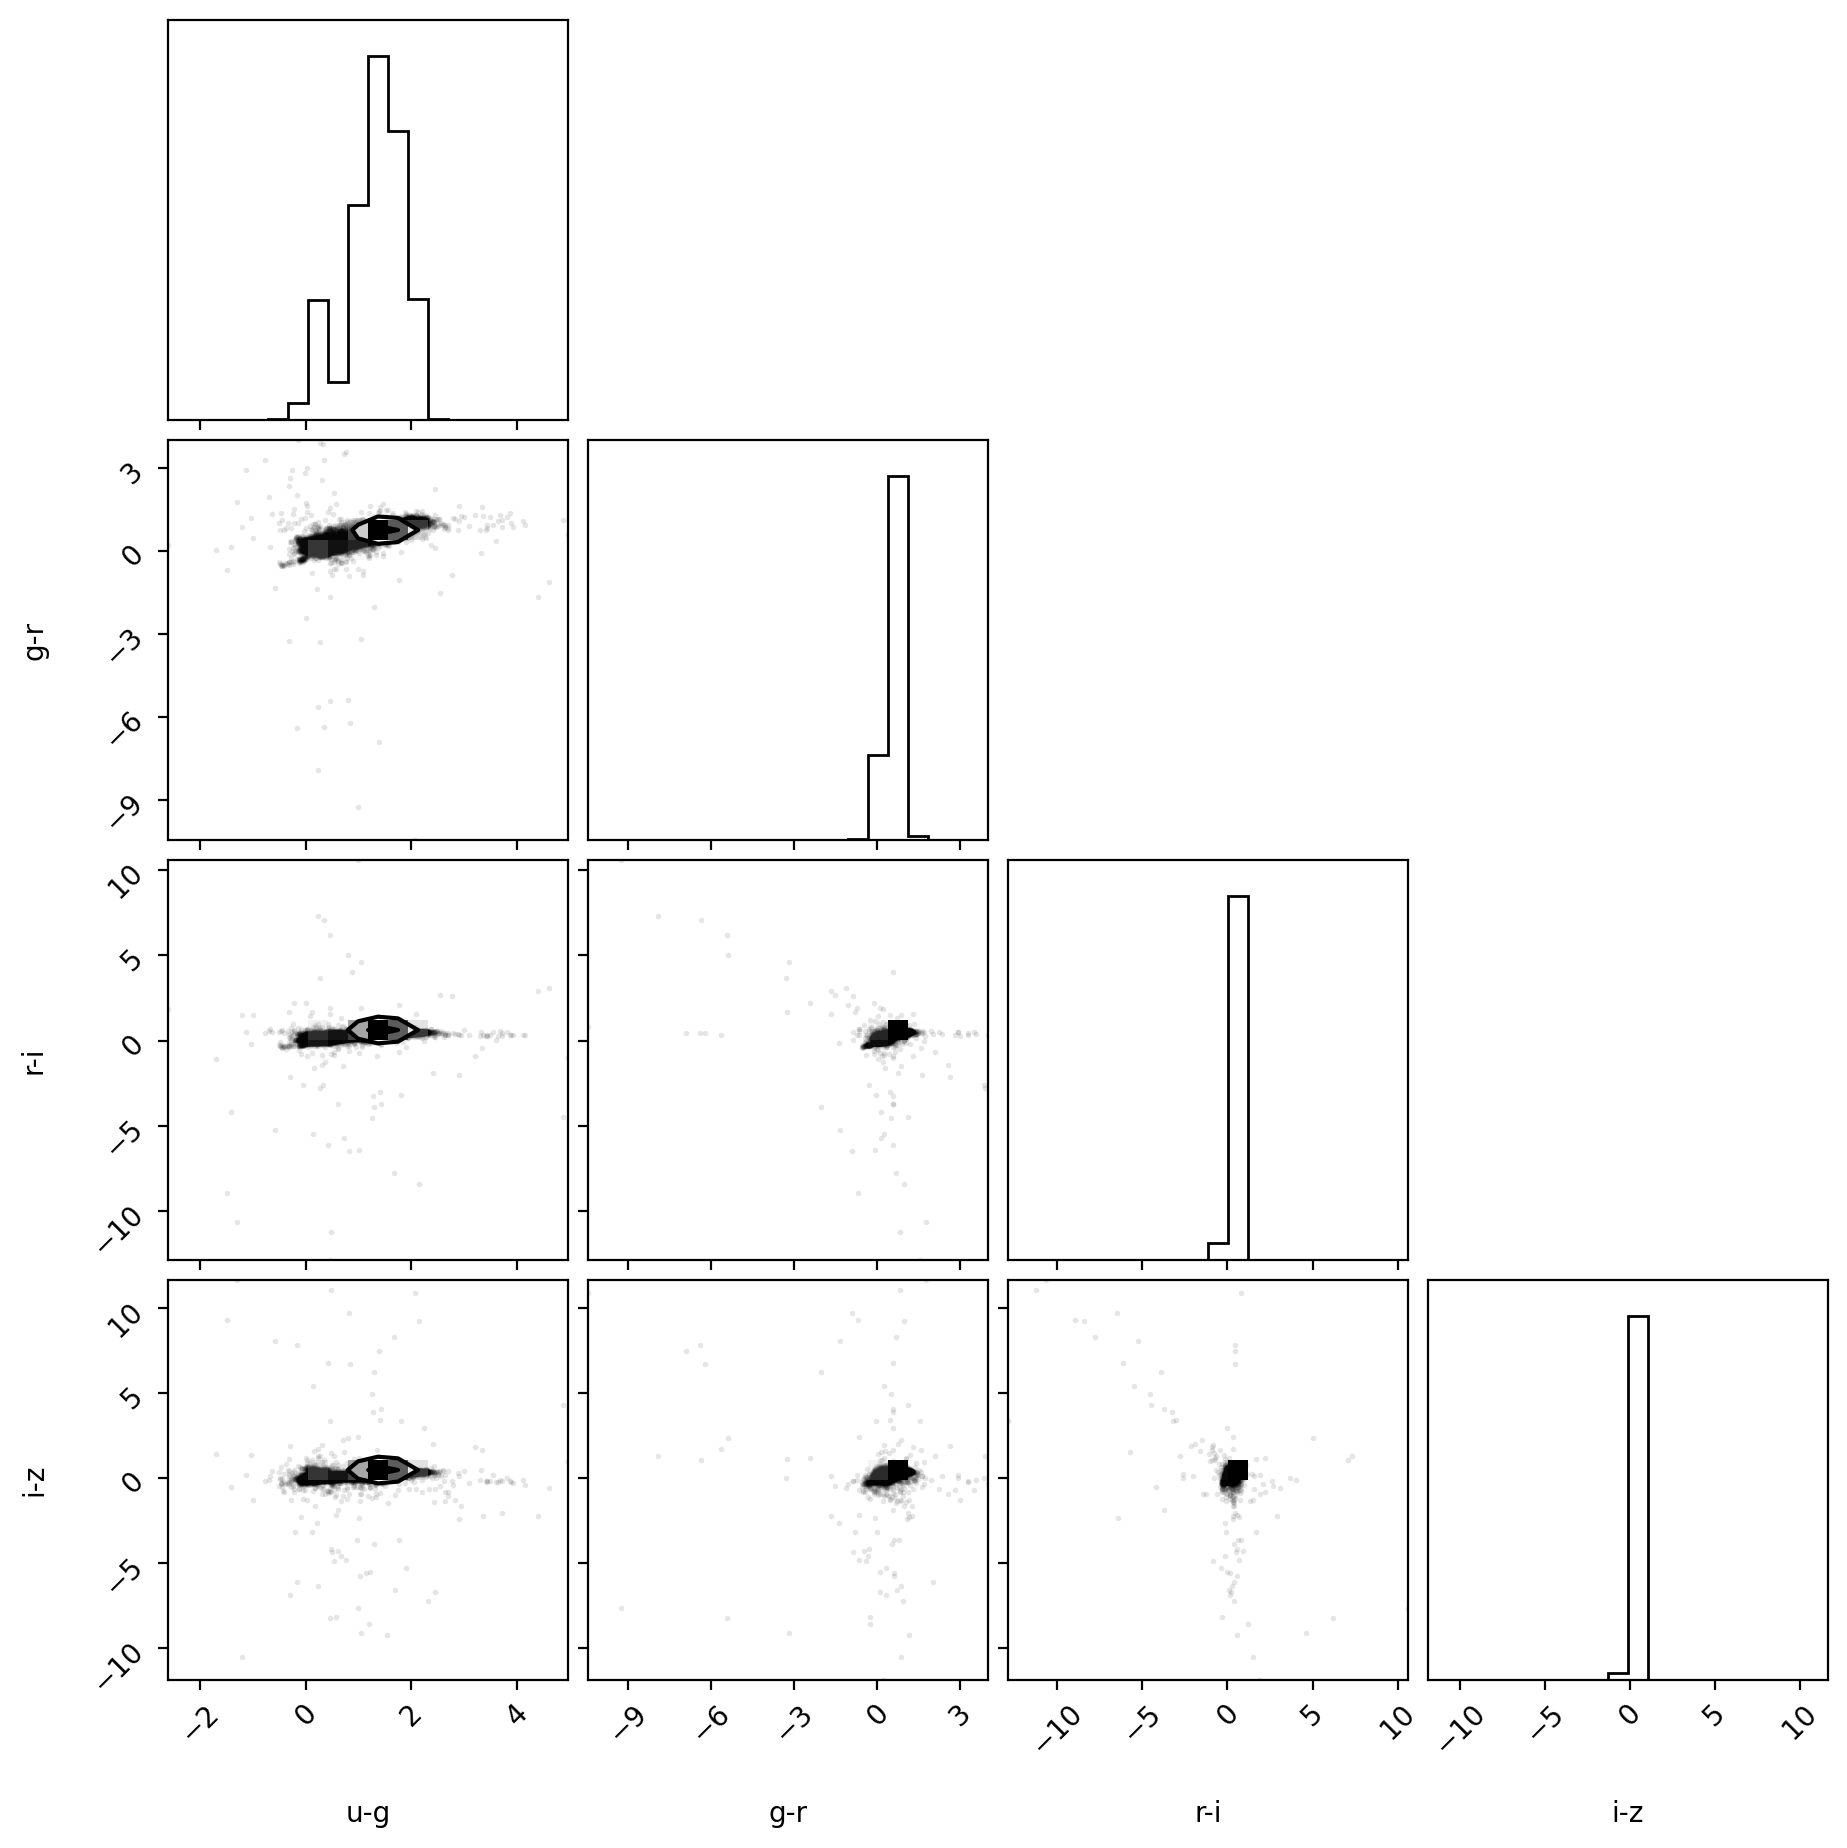

In [5]:
import corner
fig = corner.corner(np.array([u_g,g_r,r_i,i_z]).T, labels=legends)
plt.show()

### Color Distribution

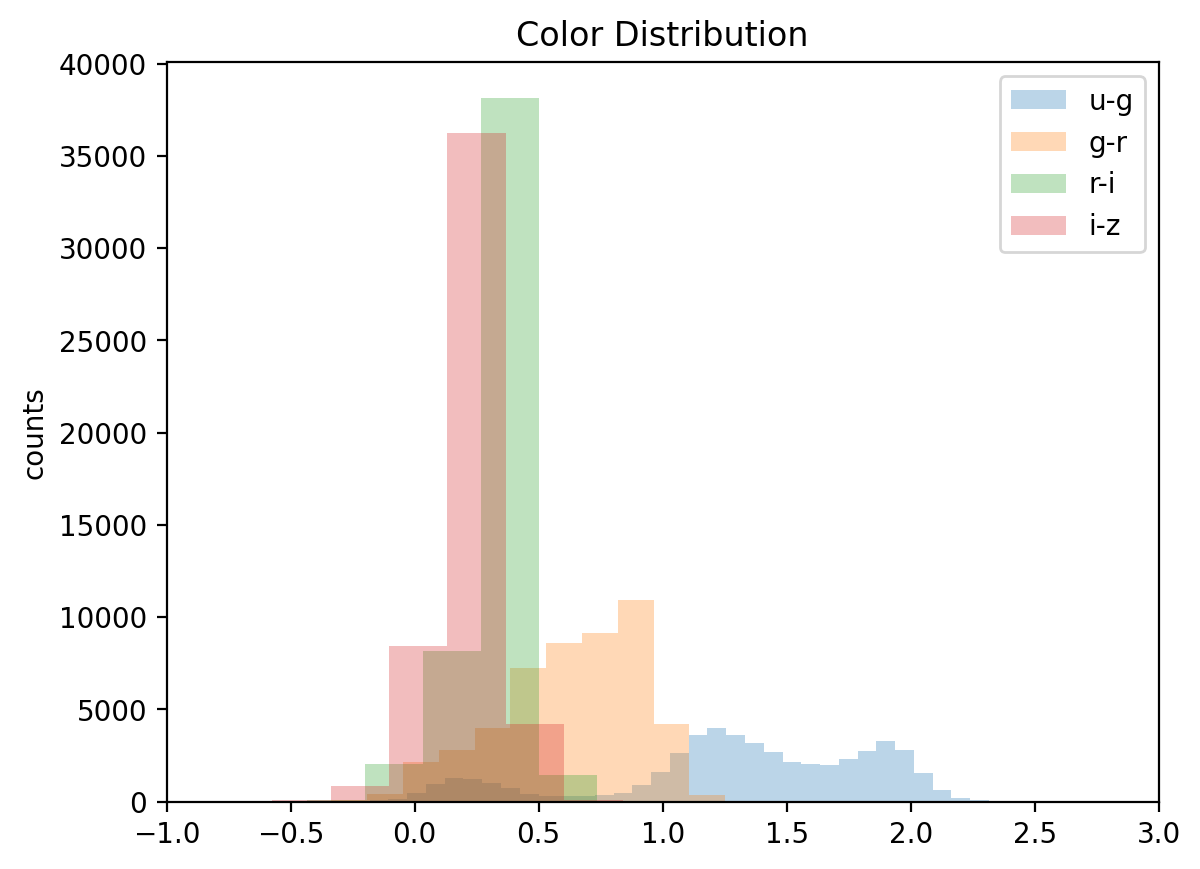

In [6]:
plt.hist(u_g, bins=100, alpha=0.3, label='u-g')
plt.hist(g_r, bins=100, alpha=0.3, label='g-r')
plt.hist(r_i, bins=100, alpha=0.3, label='r-i')
plt.hist(i_z, bins=100, alpha=0.3, label='i-z')
plt.ylabel('counts')
plt.xlim(-1.0, 3.0)
plt.title('Color Distribution')
plt.legend();

### Galaxies or Quasars?

In [7]:
galaxies_idx = np.array(np.where(data['class']=='GALAXY'))
quasars_idx  = np.array(np.where(data['class']=='QSO'))

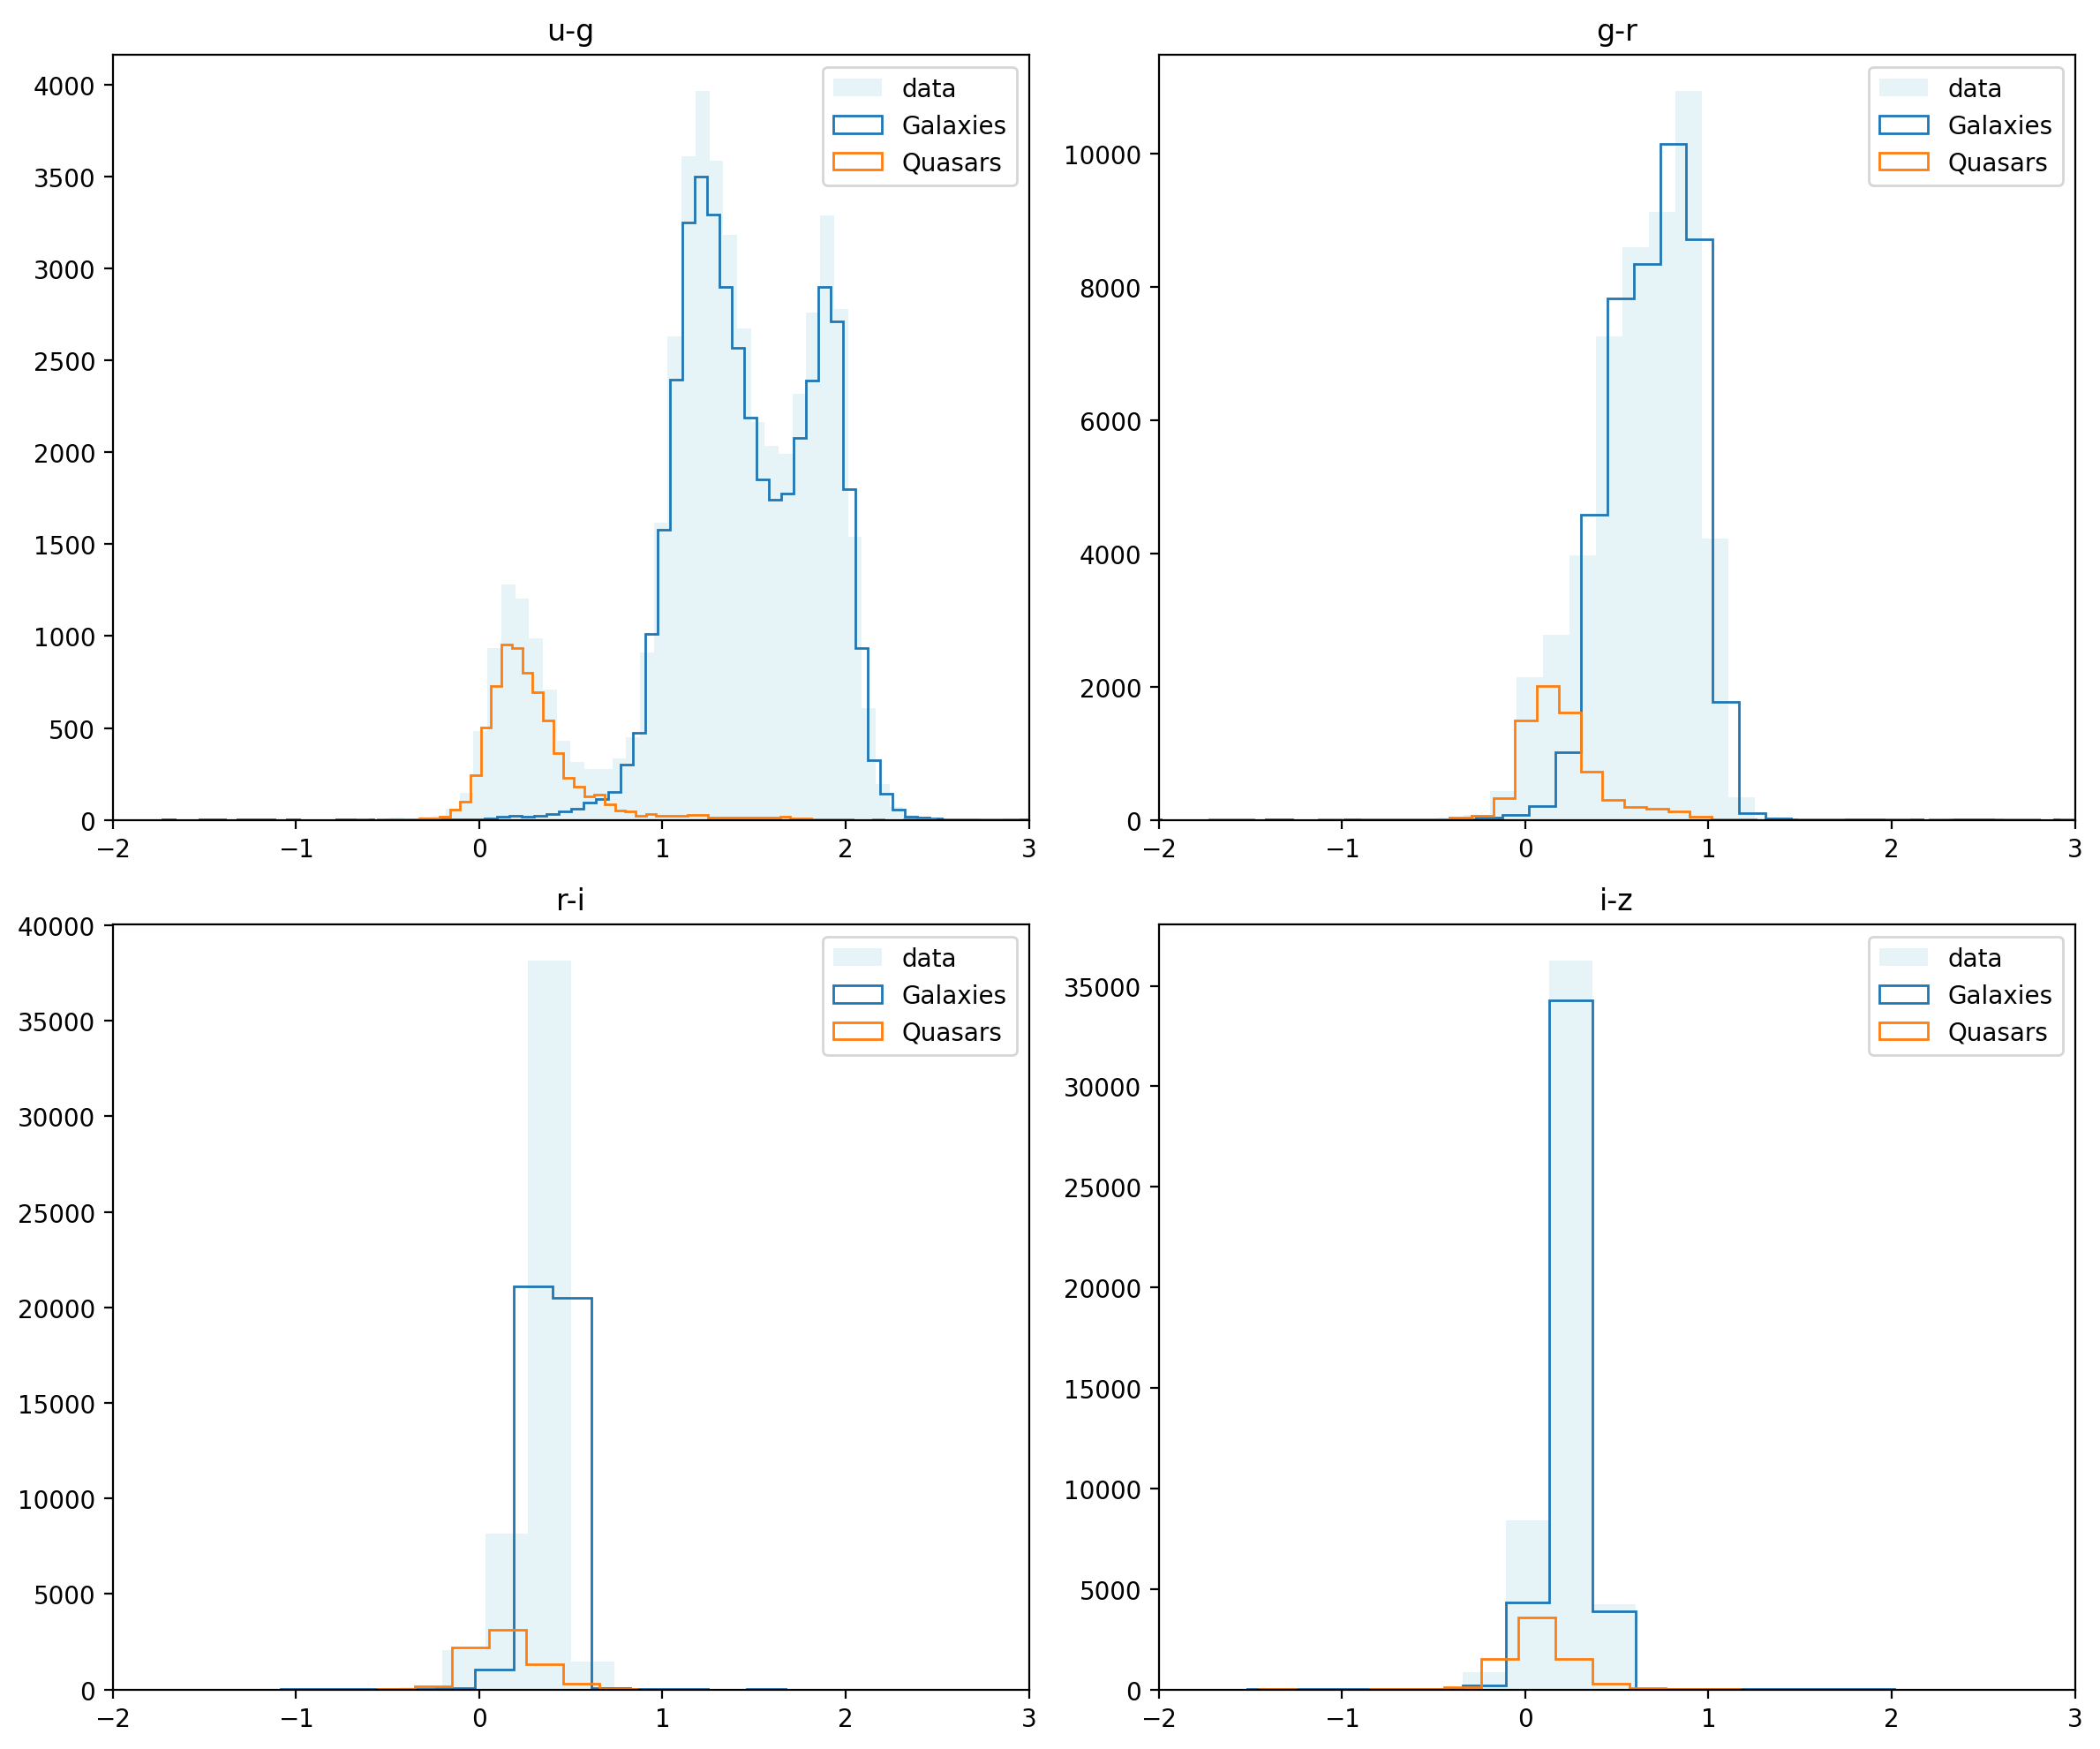

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for i, ax, xlabel in zip(np.arange(0,4), axes.flatten(), legends):
    dataset = ND_dataset[:,i]
    ax.hist(dataset, bins=100, label='data', color='lightblue', alpha=0.3)
    ax.hist(dataset[labels_01==0], bins=100, histtype='step', label='Galaxies')
    ax.hist(dataset[labels_01==1], bins=100, histtype='step', label='Quasars')
    ax.legend()
    ax.set_xlim(-2, 3)
    ax.set_title(xlabel)

plt.tight_layout();

## Deep Learning part
### Scale and train/test split

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [10]:
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(ND_dataset)

In [11]:
X_train_all, X_test_all, y_train_all, y_test_all =  train_test_split(ND_dataset, labels_01, test_size=0.30, random_state=1)

### Multi-Layer Perceptron classifier (MLP)

In [12]:
mlp_clf = MLPClassifier(
    hidden_layer_sizes=5,
    activation='relu',
    solver='adam',
    alpha=0,
    learning_rate_init=0.001,
    max_iter=2000
)

In [13]:
mlp_clf.fit(X_train_all[:1000], y_train_all[:1000])

MLPClassifier(alpha=0, hidden_layer_sizes=5, max_iter=2000)

In [14]:
y_prob = mlp_clf.predict_proba(X_test_all)[:,1]

Text(0.5, 1.0, 'ROC Curve')

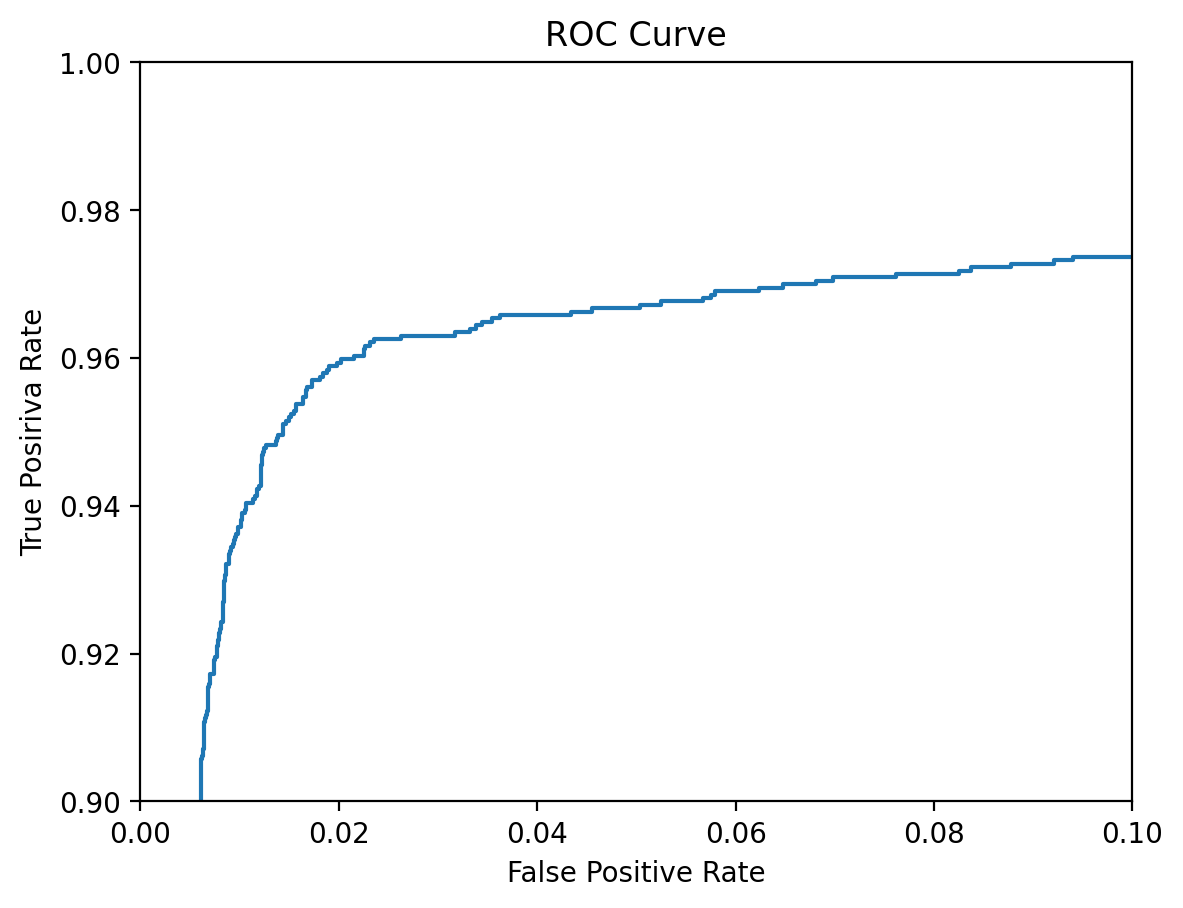

In [15]:
# ROC Curve
fpr, tpr, threshold = roc_curve(y_test_all, y_prob)
plt.plot(fpr, tpr)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Posiriva Rate')
plt.title('ROC Curve')

### Hyper-parameters optimization

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
mlpc = MLPClassifier(max_iter=5000)

hyper_params = {
    'hidden_layer_sizes': [5, (5,5), 10],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

In [18]:
clf = GridSearchCV(mlpc, hyper_params, n_jobs=-1, cv=3, verbose=3)
clf.fit(X_train_all, y_train_all)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=5000), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [5, (5, 5), 10],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=3)

In [19]:
print('Best Parameters:\n', clf.best_params_)

Best Parameters:
 {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (5, 5), 'learning_rate': 'constant', 'solver': 'adam'}


In [20]:
best_params = clf.best_params_ 

In [21]:
mlp_best = MLPClassifier(
    activation=best_params['activation'],
    alpha=best_params['alpha'],
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    learning_rate=best_params['learning_rate'],
    solver=best_params['solver'],
    max_iter=5000,
    random_state=42
)

In [22]:
mlp_best.fit(X_train_all, y_train_all)

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(5, 5),
              max_iter=5000, random_state=42)

In [23]:
train_score = mlp_best.score(X_train_all, y_train_all)
test_score = mlp_best.score(X_test_all, y_test_all)

print(f'Training Accuracy: {train_score:.4f}')
print(f'Test Accuracy: {test_score:.4f}')

Training Accuracy: 0.9857
Test Accuracy: 0.9857


In [24]:
y_prob = mlp_best.predict_proba(X_test_all)[:,1]

Text(0.5, 1.0, 'ROC Curve')

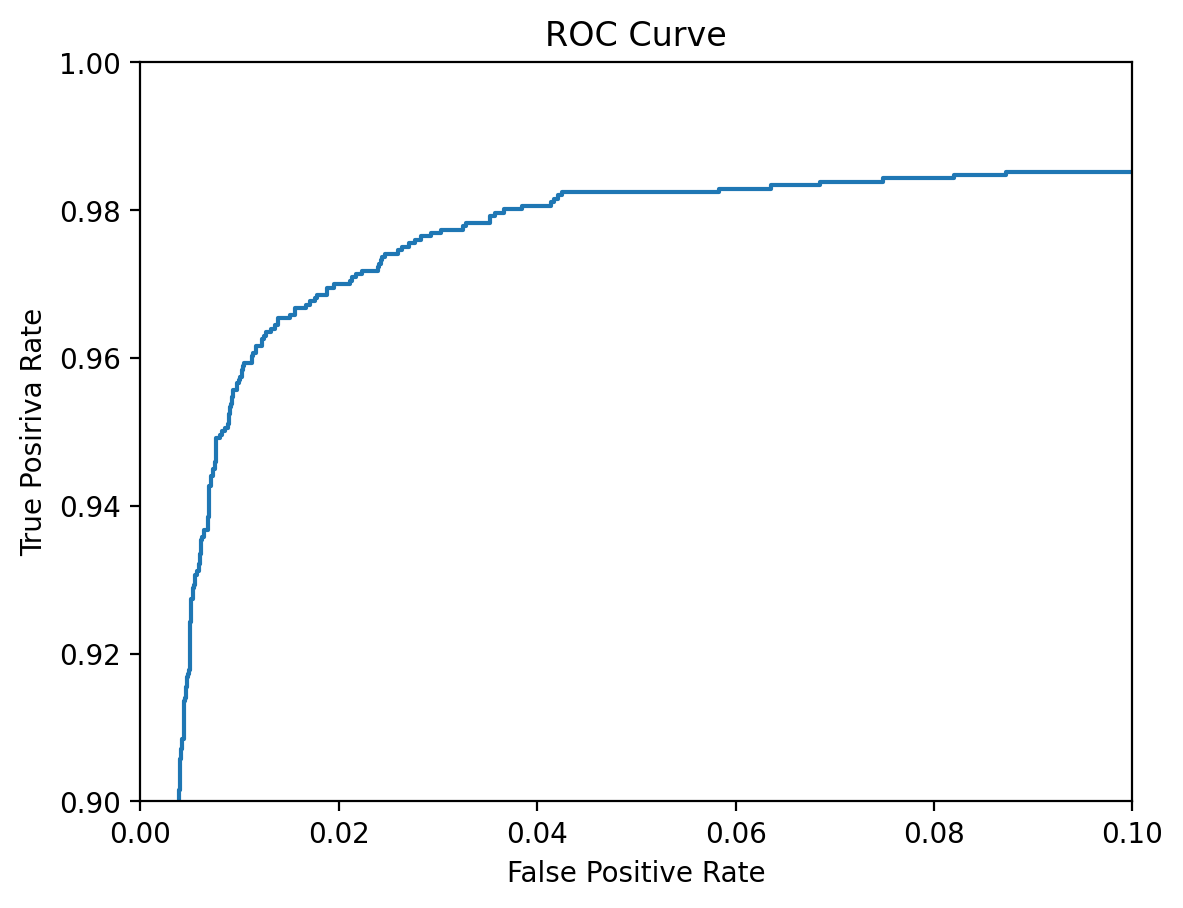

In [25]:
fpr, tpr, threshold = roc_curve(y_test_all, y_prob)
plt.plot(fpr, tpr)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Posiriva Rate')
plt.title('ROC Curve')

In [26]:
y_pred = mlp_best.predict_proba(X_test_all)
y_pred_labels = np.argmax(y_pred, axis = 1)  # from (15000, 2) --> (15000,)

In [27]:
completeness, contamination = completeness_contamination(y_pred_labels, y_test_all)

print(f'Completeness:  {completeness:.3f}')
print(f'Contamination: {contamination:.3f}')

Completeness:  0.946
Contamination: 0.046


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [29]:
print("Classification Report:")
print(classification_report(y_test_all, y_pred_labels))
print("ROC AUC Score:", roc_auc_score(y_test_all, y_prob))

# Matrice di confusione
print("Confusion Matrix:")
print(confusion_matrix(y_test_all, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12836
           1       0.95      0.95      0.95      2164

    accuracy                           0.99     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.99      0.99      0.99     15000

ROC AUC Score: 0.9924839536907807
Confusion Matrix:
[[12738    98]
 [  116  2048]]
